In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from matplotlib import pyplot as plt
from torchsummary import summary
# Training settings
batch_size = 64

# TODO dataset 和 dataloader
# MNIST Dataset
# MNIST数据集已经集成在pytorch datasets中，可以直接调用
train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
import warnings

warnings.filterwarnings('ignore')

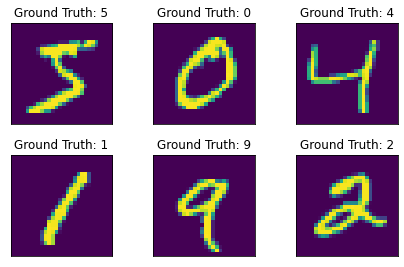

In [7]:

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  img = train_dataset.data[i].reshape(28, 28)
  plt.imshow(img)
  plt.title("Ground Truth: {}".format(train_dataset.targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

## 定义网络


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        in_dim=28*28
        n_hidden_1=300
        n_hidden_2 = 100
        out_dim=10
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.ReLU(True))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
        """
        这里的Sequential()函数的功能是将网络的层组合到一起。
        """

    def forward(self, x):
        in_size = x.size(0)
        x = x.view(in_size, -1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x:64*10
        # print(x.size())
        return F.log_softmax(x)

## 定义训练与测试

In [4]:
def train(epoch,op):
    model.train()
    # enumerate()枚举、列举，对于一个可迭代/遍历的对象，enumerate将其组成一个索引序列，利用它可以同时获得索引和值
    for batch_idx, (data, target) in enumerate(train_loader):  # batch_idx是enumerate（）函数自带的索引，从0开始
        # data.size():[64, 1, 28, 28]
        # target.size():[64]
        output = model(data.cuda())
        # print(batch_idx)
        # output:64*10
        loss = F.nll_loss(output, target.cuda())
        # 每200次，输出一次数据
        # if batch_idx % 200 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.
        #           format(
        #         epoch,
        #         batch_idx * len(data),
        #         len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader),
        #         loss.item()))
        optimizer=op
        optimizer.zero_grad()   # 所有参数的梯度清零
        loss.backward()         #即反向传播求梯度
        optimizer.step()        #调用optimizer进行梯度下降更新参数



def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data.cuda())
        # 累加loss
        test_loss += F.nll_loss(output, target.cuda(), size_average=False).item()
        # get the index of the max log-probability
        # 找出每列（索引）概率意义下的最大值
        pred = output.data.max(1, keepdim=True)[1]
        # print(pred)
        correct += pred.eq(target.data.view_as(pred).cuda()).cuda().sum()

    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss,acc

## 定义优化方式

In [16]:
model = Net()
model.cuda()
summary(model, (1, 28, 28))
op1 = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 300]         235,500
              ReLU-2                  [-1, 300]               0
            Linear-3                  [-1, 100]          30,100
              ReLU-4                  [-1, 100]               0
            Linear-5                   [-1, 10]           1,010
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.02
Estimated Total Size (MB): 1.03
----------------------------------------------------------------


## 训练&测试


test num0

Test set: Average loss: 2.2186, Accuracy: 5311/10000 (53%)

test num1

Test set: Average loss: 1.9939, Accuracy: 6717/10000 (67%)

test num2

Test set: Average loss: 1.4633, Accuracy: 7203/10000 (72%)

test num3

Test set: Average loss: 0.9723, Accuracy: 7904/10000 (79%)

test num4

Test set: Average loss: 0.7240, Accuracy: 8243/10000 (82%)

test num5

Test set: Average loss: 0.5932, Accuracy: 8483/10000 (85%)

test num6

Test set: Average loss: 0.5158, Accuracy: 8659/10000 (87%)

test num7

Test set: Average loss: 0.4654, Accuracy: 8748/10000 (87%)

test num8

Test set: Average loss: 0.4293, Accuracy: 8835/10000 (88%)

test num9

Test set: Average loss: 0.4038, Accuracy: 8895/10000 (89%)

test num10

Test set: Average loss: 0.3847, Accuracy: 8925/10000 (89%)

test num11

Test set: Average loss: 0.3694, Accuracy: 8951/10000 (90%)

test num12

Test set: Average loss: 0.3575, Accuracy: 8982/10000 (90%)

test num13

Test set: Average loss: 0.3476, Accuracy: 9003/10000 (90%)

te

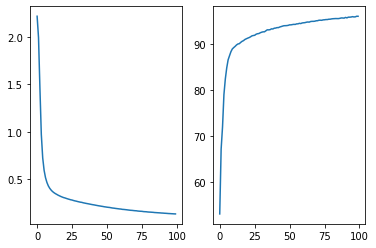

In [17]:
loss_arr = []
acc_arr=[]
for epoch in range(0, 100):
    print("test num"+str(epoch))
    train(epoch,op1)
    loss,acc = test()
    loss_arr.append(loss)
    acc_arr.append(acc)
plt.subplot(1,2,1)
plt.plot(range(0,100),loss_arr)
plt.subplot(1,2,2)
plt.plot(range(0,100),acc_arr)
plt.show()
torch.save(model.state_dict(), 'fc_mnist.pkl')

## 尝试Adam优化

test num0

Test set: Average loss: 0.1265, Accuracy: 9620/10000 (96%)

test num1

Test set: Average loss: 0.0974, Accuracy: 9699/10000 (97%)

test num2

Test set: Average loss: 0.0789, Accuracy: 9757/10000 (98%)

test num3

Test set: Average loss: 0.0869, Accuracy: 9747/10000 (97%)

test num4

Test set: Average loss: 0.0707, Accuracy: 9798/10000 (98%)



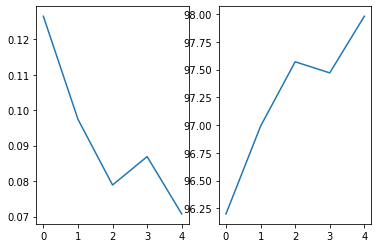

In [7]:
model = Net()#不重新初始化，model参数会保留
model.cuda()
op2 = optim.Adam(model.parameters(), lr=0.001)
loss_arr = []
acc_arr=[]
for epoch in range(0, 5):
    print("test num"+str(epoch))
    train(epoch,op2)
    loss,acc = test()
    loss_arr.append(loss)
    acc_arr.append(acc)
plt.subplot(1,2,1)
plt.plot(range(0,5),loss_arr)
plt.subplot(1,2,2)
plt.plot(range(0,5),acc_arr)
plt.show()
torch.save(model.state_dict(), 'adamfc_mnist.pkl')

## 尝试CNN

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 18, 18]             122
            Conv2d-2            [-1, 1, 10, 10]              82
            Linear-3                   [-1, 10]           1,010
Total params: 1,214
Trainable params: 1,214
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
test num0

Test set: Average loss: 2.3031, Accuracy: 1060/10000 (11%)

test num1

Test set: Average loss: 2.3024, Accuracy: 1057/10000 (11%)

test num2

Test set: Average loss: 2.3019, Accuracy: 1059/10000 (11%)

test num3

Test set: Average loss: 2.3015, Accuracy: 959/10000 (10%)

test num4

Test set: Average loss: 2.3011, Accuracy: 1132/10000 (11%)

test num5

T

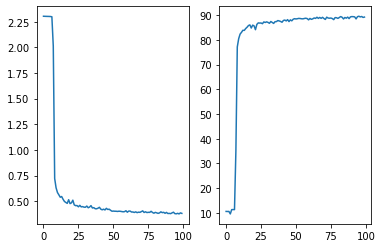

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 输入1通道，输出1通道，kernel 10*10
        self.conv1 = nn.Conv2d(1,1,kernel_size=11)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=9)
        

        self.mp = nn.MaxPool2d(2)
        # fully connect
        self.fc = nn.Linear(100, 10)#（in_features, out_features）

    def forward(self, x):
        # in_size = 64
        # one batch 此时的x是包含batchsize维度为4的tensor，即(batchsize，channels，x，y)
        # x.size(0)指batchsize的值    把batchsize的值作为网络的in_size
        in_size = x.size(0)
        # x: 64*1*28*28
        x = F.relu(self.conv1(x))
        # x: 64*10*12*12  (n+2p-f)/s + 1 = 28 - 5 + 1 = 24,所以在没有池化的时候是24*24,池化层为2*2 ，所以池化之后为12*12
        x = F.relu(self.conv2(x))
        # x: 64*20*4*4 同理，没有池化的时候是12 - 5 + 1 = 8 ，池化后为4*4
        

        x = x.view(in_size, -1)  # 平铺 tensor 相当于resharp
        
        # print(x.size())
        # x: 64*320
        x = self.fc(x)
        
        # x:64*10
        # print(x.size())
        return F.log_softmax(x)  #64*10
model = Net()#不重新初始化，model参数会保留
model.cuda()
summary(model, (1, 28, 28))
op2 = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
loss_arr = []
acc_arr=[]
for epoch in range(0, 100):
    print("test num"+str(epoch))
    train(epoch,op2)
    loss,acc = test()
    loss_arr.append(loss)
    acc_arr.append(acc)
torch.save(model.state_dict(), 'cnn_mnist.pkl')
plt.subplot(1,2,1)
plt.plot(range(0,100),loss_arr)
plt.subplot(1,2,2)
plt.plot(range(0,100),acc_arr)
plt.show()

## 测试自己生成的数据集

### 重写dataset类

In [ ]:
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import  torchvision
TRANSFORM = torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])
class ImageDataset(Dataset):
    def __init__(self, image_list, label_list):
        self.data = []
        self.label = []
        for i in range(len(image_list)):
            img = Image.open(image_list[i])
            self.data.append(TRANSFORM(img))
            img.close()
            self.label.append(int(label_list[i]))
        self.label = torch.Tensor(self.label)

    def __getitem__(self, index):
        return torch.Tensor(self.data[index]),self.label[index]
        #return torch.Tensor(self.data[index]).unsqueeze(1).expand(512,1,28,28),torch.Tensor([self.label[index]]).expand(512)

    def __len__(self):
        return len(self.data)
ORIGIN_DATA_SIZE=20
def load():
    np.random.seed(1)
    torch.manual_seed(1)
    image_list = []
    label_list = []
    for i in range(ORIGIN_DATA_SIZE):
        for idx in range(10):
            s=str(idx)
            image_list.append("/content/drive/MyDrive/my_data/"+s+"/"+s+"_"+str(i+1)+".png")
            label_list.append(idx)
    train_data = ImageDataset(image_list,label_list)
    np.random.seed()
    torch.seed()
    return train_data

torch.Size([1, 28, 28])


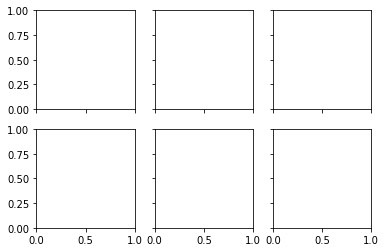

In [ ]:
mytest_dataset = load()
mytest_loader=torch.utils.data.DataLoader(mytest_dataset,batch_size=batch_size, shuffle=True)
fig, ax = plt.subplots(nrows=2, ncols=3, sharex='all', sharey='all')
ax = ax.flatten()
print(mytest_dataset.data[i].shape)

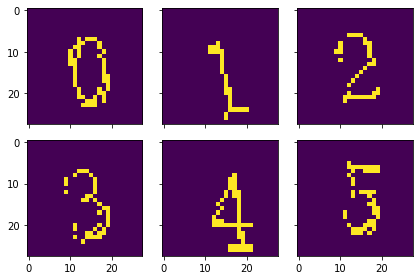

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex='all', sharey='all')
ax = ax.flatten()
for i in range(6):
    img = mytest_dataset.data[i].reshape(28, 28)
    # ax[i].imshow(img,cmap='Greys')
    ax[i].imshow(img)
x, y = next(iter(mytest_loader))
plt.tight_layout()
plt.show()

### 利用之前的预训练模型预测

In [ ]:
class Netfc(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        in_dim=28*28
        n_hidden_1=300
        n_hidden_2 = 100
        out_dim=10
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.ReLU(True))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
        """
        这里的Sequential()函数的功能是将网络的层组合到一起。
        """

    def forward(self, x):
        in_size = x.size(0)
        x = x.view(in_size, -1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x:64*10
        # print(x.size())
        return F.log_softmax(x)
class Netcnn(nn.Module):
    def __init__(self):
        super(Netcnn, self).__init__()
        # 输入1通道，输出10通道，kernel 5*5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 300, 5)
        self.conv3 = nn.Conv2d(300, 100, 3)

        self.mp = nn.MaxPool2d(2)
        # fully connect
        self.fc = nn.Linear(100, 10)#（in_features, out_features）

    def forward(self, x):
        # in_size = 64
        # one batch 此时的x是包含batchsize维度为4的tensor，即(batchsize，channels，x，y)
        # x.size(0)指batchsize的值    把batchsize的值作为网络的in_size
        in_size = x.size(0)
        # x: 64*1*28*28
        x = F.relu(self.mp(self.conv1(x)))
        # x: 64*10*12*12  (n+2p-f)/s + 1 = 28 - 5 + 1 = 24,所以在没有池化的时候是24*24,池化层为2*2 ，所以池化之后为12*12
        x = F.relu(self.mp(self.conv2(x)))
        # x: 64*20*4*4 同理，没有池化的时候是12 - 5 + 1 = 8 ，池化后为4*4
        x = F.relu(self.mp(self.conv3(x)))
        # 输出x : 64*40*2*2

        x = x.view(in_size, -1)  # 平铺 tensor 相当于resharp
        # print(x.size())
        # x: 64*320
        x = self.fc(x)
        # x:64*10
        # print(x.size())
        return F.log_softmax(x)  #64*10
best_model = Netcnn()
best_model.load_state_dict(torch.load('/content/cnn_mnist.pkl'))
def predic_t(bmodel,test):
    model.eval()
    total_count = 0
    total_loss = 0
    with torch.no_grad():
        for data, target in test:
            data, target = Variable(data, volatile=True), Variable(target)
            output = bmodel(data)
            target=target.long()
            # 累加loss
            total_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            # 找出每列（索引）概率意义下的最大值
            pred = output.data.max(1, keepdim=True)[1]
            # print(pred)
            total_count += pred.eq(target.data.view_as(pred)).sum()

    total_loss /= len(test.dataset)
    acc = 100. * total_count / len(test.dataset)
    print('\nMyTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            total_loss, total_count, len(test.dataset),
            100. * total_count / len(test.dataset)))
    return total_loss,acc

predic_t(best_model,mytest_loader)


MyTest set: Average loss: 2.2266, Accuracy: 82/200 (41%)



(2.2265898895263674, tensor(41.))

## 加入bn层

In [ ]:
class Netcnn(nn.Module):
    def __init__(self):
        super(Netcnn, self).__init__()
        # 输入1通道，输出10通道，kernel 5*5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 300, 5)
        self.bn2 = nn.BatchNorm2d(300)
        self.conv3 = nn.Conv2d(300, 100, 3)
        self.bn3 = nn.BatchNorm2d(100)

        self.mp = nn.MaxPool2d(2)
        # fully connect
        self.fc = nn.Linear(100, 10)#（in_features, out_features）

    def forward(self, x):
        # in_size = 64
        # one batch 此时的x是包含batchsize维度为4的tensor，即(batchsize，channels，x，y)
        # x.size(0)指batchsize的值    把batchsize的值作为网络的in_size
        in_size = x.size(0)
        # x: 64*1*28*28
        x = F.relu(self.mp(self.bn1(self.conv1(x))))
        
        # x: 64*10*12*12  (n+2p-f)/s + 1 = 28 - 5 + 1 = 24,所以在没有池化的时候是24*24,池化层为2*2 ，所以池化之后为12*12
        x = F.relu(self.mp(self.bn1(self.conv2(x))))
        # x: 64*20*4*4 同理，没有池化的时候是12 - 5 + 1 = 8 ，池化后为4*4
        x = F.relu(self.mp(self.bn1(self.conv3(x))))
        # 输出x : 64*40*2*2

        x = x.view(in_size, -1)  # 平铺 tensor 相当于resharp
        # print(x.size())
        # x: 64*320
        x = self.fc(x)
        # x:64*10
        # print(x.size())
        return F.log_softmax(x)  #64*10
def train(epoch,op):
    model.train()
    # enumerate()枚举、列举，对于一个可迭代/遍历的对象，enumerate将其组成一个索引序列，利用它可以同时获得索引和值
    for batch_idx, (data, target) in enumerate(train_loader):  # batch_idx是enumerate（）函数自带的索引，从0开始
        output = model(data.cuda())
        loss = F.nll_loss(output, target.cuda())
        optimizer=op
        optimizer.zero_grad()   # 所有参数的梯度清零
        loss.backward()         #即反向传播求梯度
        optimizer.step()        #调用optimizer进行梯度下降更新参数



def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data.cuda())
        # 累加loss
        test_loss += F.nll_loss(output, target.cuda(), size_average=False).item()
        # get the index of the max log-probability
        # 找出每列（索引）概率意义下的最大值
        pred = output.data.max(1, keepdim=True)[1]
        # print(pred)
        correct += pred.eq(target.data.view_as(pred).cuda()).cuda().sum()

    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss,acc
loss_arr = []
acc_arr=[]
for epoch in range(0, 5):
    print("test num"+str(epoch))
    train(epoch,op2)
    loss,acc = test()
    loss_arr.append(loss)
    acc_arr.append(acc)
torch.save(model.state_dict(), 'cnn_mnist_bn.pkl')
plt.subplot(1,2,1)
plt.plot(range(0,5),loss_arr)
plt.subplot(1,2,2)
plt.plot(range(0,5),acc_arr)
plt.show()

NameError: ignored

In [ ]:

def predic_t(bmodel,test):
    model.eval()
    total_count = 0
    total_loss = 0
    with torch.no_grad():
        for data, target in test:
            data, target = Variable(data, volatile=True), Variable(target)
            output = bmodel(data.cuda())
            target=target.long()
            # 累加loss
            total_loss += F.nll_loss(output, target.cuda(), size_average=False).item()
            # get the index of the max log-probability
            # 找出每列（索引）概率意义下的最大值
            pred = output.data.max(1, keepdim=True)[1]
            # print(pred)
            total_count += pred.eq(target.data.view_as(pred).cuda()).cuda().sum()

    total_loss /= len(test.dataset)
    acc = 100. * total_count / len(test.dataset)
    print('\nMyTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            total_loss, total_count, len(test.dataset),
            100. * total_count / len(test.dataset)))
    return total_loss,acc

predic_t(model,mytest_loader)


MyTest set: Average loss: 1.3001, Accuracy: 132/200 (66%)



(1.3001054191589356, tensor(66., device='cuda:0'))

In [ ]:
train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)
print(train_dataset.data[0].shape)

torch.Size([28, 28])
